# Machine learning model based on Healthcare Diabetes Dataset 

## Problem understanding

### Introduction  
Diabetes is a life-long illness that affects millions of people around the world and that has serious long-term negative consequences if not diagnosed early and managed. Early detection is crucial for getting ahead of the disease, and data science can have a significant impact on this.

In this notebook, I would like to create a machine learning model that can predict whether a person is suspected to have diabetes or not, using the information about his/her medical history and demographics. The dataset I used consists of data such as **glucose, BMI, insulin, age**, and other important factors.

### Objective:  
To create a machine learning model that uses health-related indicators to predict if a person has diabetes **(Outcome = 1)** or not **(Outcome = 0)**.  
This is a binary classification problem with tabular, structured medical data.

### Features
1. 9 input features: all clinical and numeric (no dates, no text).  
2. One identifier, **Id**, is not helpful for modeling and should be dropped.  
3. Target: **Outcome** (0 or 1)  

## Initial assumptions before modeling
1. **Zero values represent missing data**  
It's not really possible to have `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, and `BMI` be equal to 0 for a person. I thought maybe these zeros are missing or unrecorded medical readings.

2. **Real-world data is noisy and imperfect**    
Since this dataset is most likely derived from the actual patients, it is expected to have outliers, recording errors, and overall inconsistent data, particularly in features like `Insulin`.

3. **All features are somewhat equally useful**  
Since everything has been measured to predict diabetes, everything can be significant.

5. **Insulin will be the strongest predictor**  
`Insulin` levels are positively associated with the normal regulation of glucose levels, so it should be the most important predictor.

6. **The dataset is cross-sectional, not longitudinal**  
I thought the dataset didn't record changes over time. I approached the problem as a static classification task rather than a time-dependent one because each patient is only represented once.

7. **The ID column is useless for forecasting**     
Since the `Id` field is only used as an identifier, it should be removed before modeling to prevent noise or leakage.

8. **Imbalanced dataset**  
I assumed that the dataset is imbalanced, with more non-diabetic individuals than diabetic ones.

## Import all libraries

In [1]:
#data handling
import pandas as pd
import numpy as np
#model selection and evaluation
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
#preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
#imbalanced data handling
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
#SHAP for explainability
import shap
#suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# load the dataset for analysis
df = pd.read_csv(r"C:\Users\Exterpublic\Downloads\archive\Healthcare-Diabetes.csv")
df.head()
df

,Id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,6,148,72,35,0,33.6,0.627,50,1
1,2,1,85,66,29,0,26.6,0.351,31,0
2,3,8,183,64,0,0,23.3,0.672,32,1
3,4,1,89,66,23,94,28.1,0.167,21,0
4,5,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...,...
2763,2764,2,75,64,24,55,29.7,0.370,33,0
2764,2765,8,179,72,42,130,32.7,0.719,36,1
2765,2766,6,85,78,0,0,31.2,0.382,42,0
2766,2767,0,129,110,46,130,67.1,0.319,26,1


### Descriptive Analysis
Total rows: 2,768  
Binary target:
Outcome = 0 (no diabetes): 65.6%
Outcome = 1 (diabetes): 34.4%  
Slight class imbalance, but not extreme.

#### Assumptions for Modeling
1. **Glucose** and **BMI** are key predictors (confirmed in most studies).
2. **Age, Pregnancies, and DiabetesPedigreeFunction** add secondary but meaningful value.
3. **Insulin** and **SkinThickness** may be noisy; proper imputation will help, but may need regularization to reduce overfitting.
4. Feature distributions are skewed, especially **Insulin** and **DiabetesPedigreeFunction**, scaling is essential.
5. Class imbalance is moderate, but still needs to be addressed.

## Assumption: Insulin can not be 0, it is a placeholder
Can insulin be 0? According to the **American Journal of Physiology**, _"Healthy individuals consistently have non-zero basal insulin — it is always measurable."_
I tried to understand if 0 for Insulin was a true value or just a placeholder. The Insulin column had **1330** `0` values, **845** of which also had a `0 outcome` (meaning **non-diabetic**), which is highly unlikely, as the absence of insulin is typically seen only in extreme conditions, such as Type 1 diabetes. 

In [3]:
df['Insulin'].value_counts()

Insulin
0      1330
105      42
140      33
130      31
180      30
       ... 
235       1
146       1
846       1
245       1
543       1
Name: count, Length: 187, dtype: int64

In [4]:
zero_insulin = df[df['Insulin'] == 0]
count_by_outcome = zero_insulin['Outcome'].value_counts()
print("Insulin = 0 with each Outcome label:")
print(count_by_outcome)

Insulin = 0 with each Outcome label:
Outcome
0    845
1    485
Name: count, dtype: int64


This confirms that Insulin = 0 appears in both diabetics and non-diabetics.

I found that 
1. Insulin is 0 and `Outcome = 0` (non-diabetic): **845** cases
2. Insulin is 0 and `Outcome = 1` (diabetic): **485** cases  
That’s **63.5% non-diabetics** and **36.5% diabetics** among those with Insulin = 0.  

In [5]:
percent_by_outcome = zero_insulin['Outcome'].value_counts(normalize=True) * 100
print("\nPercentage breakdown:")
print(percent_by_outcome.round(2))


Percentage breakdown:
Outcome
0    63.53
1    36.47
Name: proportion, dtype: float64


Moving forward, I will assume these values **are not real measurements**, because:
1. Many **non-diabetics have Insulin = 0**, which is biologically implausible
2. Even some diabetics would have some insulin (especially Type 2)

## Skin Thickness = 0?
I figured there are **800** "0" entries for **SkinThickness**, which is not plausible. I decided to further change the **"0"** values to **"Nan"** and treat them as missing values.

In [6]:
df['SkinThickness'].value_counts()

SkinThickness
0      800
32     114
30     102
23      82
27      81
28      74
18      74
33      71
39      70
31      69
25      63
37      61
29      61
22      60
19      59
40      58
41      56
17      55
26      55
36      52
35      48
15      47
20      45
24      43
42      42
13      41
21      37
46      33
12      28
34      27
38      25
14      21
16      21
43      21
11      20
45      19
10      18
44      17
48      16
49      14
47      11
50      10
8        8
52       6
54       6
7        5
63       4
51       4
56       4
60       3
99       3
59       2
110      2
Name: count, dtype: int64

In [7]:
#shows count of 0 values in each column
zero_counts = (df == 0).sum()
#filter to show only columns with at least one 0 value
zero_counts = zero_counts[zero_counts > 0]
#display
print("Columns with 0 values:")
print(zero_counts)

Columns with 0 values:
Pregnancies       412
Glucose            18
BloodPressure     125
SkinThickness     800
Insulin          1330
BMI                39
Outcome          1816
dtype: int64


# Preprocessing 

In [8]:
#replace 0 with NaN in preprocessing:
columns_with_missing = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[columns_with_missing] = df[columns_with_missing].replace(0, np.nan)

In [9]:
missing_counts = df[columns_with_missing].isna().sum()
print("Missing values after replacement:")
print(missing_counts)
df

Missing values after replacement:
Glucose            18
BloodPressure     125
SkinThickness     800
Insulin          1330
BMI                39
dtype: int64


,Id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,2,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,3,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,4,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,5,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...,...
2763,2764,2,75.0,64.0,24.0,55.0,29.7,0.370,33,0
2764,2765,8,179.0,72.0,42.0,130.0,32.7,0.719,36,1
2765,2766,6,85.0,78.0,NaN,NaN,31.2,0.382,42,0
2766,2767,0,129.0,110.0,46.0,130.0,67.1,0.319,26,1


In [10]:
#drop unnecessary identifier columns if they exist
df.drop(columns=[col for col in ['Id', 'id'] if col in df.columns], inplace=True)

#### Handling outliers by clipping
To fix **outliers** (some numbers in the dataset are way too big or too small), I used the `clip()` method in pandas.  
The `clip()` method allows you to set a minimum and maximum limit for the values in a column. The numbers that are smaller than the 1st percentile will be set to the 1st percentile value, and the numbers bigger than the 99th percentile will be set to the 99th percentile value. Everything in between stays the same.

In [11]:
#handle outliers by clipping each numeric feature to its 1st and 99th percentile
for col in df.columns:
    if col != 'Outcome':
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = df[col].clip(lower=lower, upper=upper)

In [12]:
#separate features (X) and target variable (y)
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

In [13]:
#identify all numeric columns for processing
numeric_features = X.columns.tolist()

### Preprocessing: Imputation + Standardization
**Assumption:** most features are numeric and may contain missing values due to data quality issues (missing insulin readings). Scaling is also essential for many ML algorithms.
- **Median imputation** in order to avoid the influence of outliers.
- **StandardScaler** makes sure features are on the same scale, it helps SHAP values remain interpretable.

In [14]:
#define a preprocessing pipeline: impute missing values using median, scale all features to have mean=0 and std=1
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_features)
])

# Modeling Pipeline and Hyperparameter Grid

In [15]:
#create a full pipeline: first preprocess the data, then apply RandomForestClassifier with class_weight to handle imbalance
pipeline = ImbPipeline([
    ('preprocess', preprocessor),
    ('rf', RandomForestClassifier(
        class_weight='balanced',  #helps deal with imbalanced classes
        random_state=42,
        n_jobs=-1                  #use all CPU cores
    ))
])

In [16]:
#define a grid of hyperparameters to search over (these affect tree size, splitting behavior, and number of trees)
param_grid = {
    'rf__n_estimators': [100, 200],          #number of trees
    'rf__max_depth': [5, 8],                 #max depth of each tree
    'rf__min_samples_split': [10, 20],       #minimum samples to split a node
    'rf__min_samples_leaf': [5, 10],         #minimum samples in a leaf node
    'rf__max_features': ['sqrt'],            #number of features to consider at each split
    'rf__max_samples': [0.6]                 #fraction of training samples used in each tree
}

# Nested Cross-Validation

**Assumption:** To avoid overfitting when tuning hyperparameters, I used **nested cross-validation**:
- The **inner loop** searches for the best hyperparameters (model tuning).
- The **outer loop** evaluates performance on truly unseen test data.

The first ML model I trained gave me an accuracy score of 100%
This ensures:
- No leakage between model tuning and testing.
- Honest estimation of real-world model performance.
- Generalization ability across different data folds.

It's computationally expensive but provides high-confidence evaluation, especially in medical applications.


In [17]:
#outer loop: evaluates generalization performance (5-fold CV)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [18]:
#inner loop: selects best hyperparameters (3-fold CV)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [19]:
#store results
outer_scores = []        #list of (accuracy, AUC) for each fold
best_params_list = []    #best parameters for each outer fold

In [20]:
#loop through outer folds
for fold, (train_ix, test_ix) in enumerate(outer_cv.split(X, y)):
    print(f"\n Outer Fold {fold + 1}")

    #split data into training and testing for current fold
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

    #perform grid search to find the best model on inner folds
    grid = GridSearchCV(
        pipeline, param_grid,
        cv=inner_cv, scoring='roc_auc',
        refit=True, n_jobs=-1
    )
    grid.fit(X_train, y_train)

    #evaluate best model on the outer fold test set
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]  #probabilities for ROC AUC

    #calculate accuracy and ROC AUC for evaluation
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    #save results and best parameters
    outer_scores.append((acc, auc))
    best_params_list.append(grid.best_params_)

    #print metrics for current fold
    print(f"Best Params: {grid.best_params_}")
    print(f"Fold Accuracy: {acc:.3f}, ROC AUC: {auc:.3f}")
    print(classification_report(y_test, y_pred))


 Outer Fold 1
Best Params: {'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__max_samples': 0.6, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}
Fold Accuracy: 0.857, ROC AUC: 0.950
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       363
           1       0.75      0.88      0.81       191

    accuracy                           0.86       554
   macro avg       0.84      0.86      0.85       554
weighted avg       0.87      0.86      0.86       554


 Outer Fold 2
Best Params: {'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__max_samples': 0.6, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}
Fold Accuracy: 0.888, ROC AUC: 0.954
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       363
           1       0.79      0.92      0.85       191

    accuracy                           0.89       554
   macro avg     

In [21]:
#after all folds,it prints overall average and standard deviation
accs, aucs = zip(*outer_scores)
print("\n Nested CV Summary")
print(f"Mean Accuracy: {np.mean(accs):.3f} ± {np.std(accs):.3f}")
print(f"Mean ROC AUC: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")


 Nested CV Summary
Mean Accuracy: 0.870 ± 0.018
Mean ROC AUC: 0.955 ± 0.005


# Final Model Training with SMOTETomek

In [22]:
#take best hyperparameters from the last fold
final_best_params = best_params_list[-1]
#strip "rf__" prefix so it can pass parameters directly to RandomForestClassifier
rf_params = {k.replace('rf__', ''): v for k, v in final_best_params.items()}

### Handling class imbalance with SMOTETomek
**Assumption:** The dataset shows class imbalance (34% diabetic vs 66% non-diabetic). This can cause the model to favor the majority class.
- **SMOTE** _(Synthetic Minority Over-sampling Technique)_ adds new synthetic diabetic samples.
- **Tomek links** remove overlapping majority samples to improve class boundary clarity.

This approach helps the model reduce bias toward predicting "non-diabetic."

In [23]:
#build the final pipeline:
# 1. preprocess the data
# 2. balance the classes using SMOTETomek (oversample + undersample)
# 3. train RandomForestClassifier with best params
final_pipeline = ImbPipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTETomek(random_state=42)),  # Resample the data
    ('rf', RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_jobs=-1,
        **rf_params
    ))
])

In [24]:
#train final model on entire dataset
final_pipeline.fit(X, y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Pregnancies', 'Glucose',
                                                   'BloodPressure',
                                                   'SkinThickness', 'Insulin',
                                                   'BMI',
                                                   'DiabetesPedigreeFunction',
                                                   'Age'])])),
                ('smote', SMOTETomek(random_state=42)),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=8,
                                        max_samples=0.6, min_samples_leaf=5,
                                        min_samples_split=10, n_estimators=200,
                                        n_jobs=-1, random_state=42))])

# SHAP Explainability

In [25]:
#extract the preprocessing and trained model steps
preprocessor = final_pipeline.named_steps['preprocess']
rf_model = final_pipeline.named_steps['rf']

In [26]:
#get the names of the features used 
feature_names = preprocessor.transformers_[0][2]

In [27]:
#apply the preprocessing steps to the full dataset
X_transformed = preprocessor.transform(X)
X_scaled_df = pd.DataFrame(X_transformed, columns=feature_names)

In [28]:
#use SHAP TreeExplainer to explain the Random Forest model
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_scaled_df)

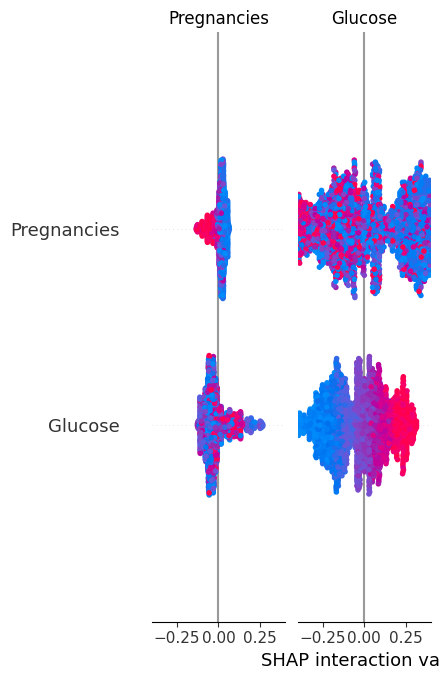

In [29]:
#visualize SHAP values to understand which features contribute the most
#if SHAP returns values for both classes, pick class 1 (diabetic = 1)
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap.summary_plot(shap_values[1], X_scaled_df)
else:
    shap.summary_plot(shap_values, X_scaled_df)

### SHAP interaction plot explained
This SHAP interaction plot shows how Pregnancies and Glucose contribute individually and together to the model’s diabetes predictions.
On the diagonal, we see the main effects:
- Glucose (bottom-right) has a strong positive effect — higher glucose values (red) push the prediction higher.
- Pregnancies (top-left) has a weaker effect, with a smaller spread of SHAP values.

The off-diagonal plots show their interaction:
- When both Glucose and Pregnancies are high (red points), the SHAP interaction values are more positive.
- This means the model gives more weight to high glucose especially when the number of pregnancies is also high.
In short, Glucose is the strongest driver, but its effect grows when combined with high Pregnancies.

### Changes made
The first ML model I trained with this dataset had an accuracy of 1.00 (or 100%), which made me realize I committed errors like **overfitting, data leakage**. For example, `df.fillna(df.median())` (missing value handling) was done outside the pipeline, which introduced a data leakage risk because I was calculating the median using the entire dataset, including test folds. Also, `SMOTETomek` was placed inside the pipeline used for `GridSearchCV` (I learned that SMOTE should never be applied before validation unless inside an inner fold and correctly isolated, which is very tricky to do right). This led to inflating model performance due to **synthetic leakage**. Later on, I changed it so that the preprocessing was fully integrated in the pipeline, SMOTE applied only in the final step, nested cross validation (reduced overfitting), and **SHAP** included so that the model was interpretable.

### Review of initial assumptions
The assumption that **zero values represented missing data** was correct, features like `Glucose`, `BloodPressure`, and `Insulin` clearly couldn’t realistically be zero, and imputing them improved data quality. I was also right in thinking the **data would be noisy**; outliers were present, especially in `Insulin`, and needed to be clipped for accuracy. The dataset being **cross-sectional** and the **ID column being useless** were both accurate assumptions and were handled correctly.  

However, not all assumptions were true. I initially thought **all features would contribute equally** to the prediction, but SHAP showed that only a few features — mainly `Glucose`, `BMI` had a strong influence. I also expected `Insulin` **to be the most important predictor**, but due to missingness and noise, it was not as helpful as anticipated. Lastly, I assumed the **dataset would be heavily imbalanced**, and while it was skewed toward non-diabetics, the imbalance was moderate. Still, applying techniques like **SMOTETomek** helped improve performance.  

In conclusion, validating these assumptions with data helped me make better decisions throughout the pipeline and build a more reliable and explainable model.

## Overall Conclusion
In this project, I developed an interpretable ML model to predict the likelihood of diabetes in individuals based on medical data.
### How the Model Works
The model takes in features such as glucose level, blood pressure, BMI, age, and insulin levels, and outputs a prediction:  
- `1` is likely diabetic  
- `0` is likely non-diabetic
### Steps implemented:
1. **Preprocessing**:
   - Missing or invalid values are replaced with `NaN` and imputed using **median**.
   - Features are **scaled** using `StandardScaler` to normalize the data.
   - Outliers are clipped to the 1st and 99th percentiles to reduce noise.

2. **MOdel selection**:
   - I used a **Random Forest Classifier**, a *powerful ensemble method that reduces overfitting and handles feature interactions* well.
   - I tuned hyperparameters using **GridSearchCV** inside a **nested cross-validation loop**, which prevents data leakage.

3. **Class imbalance handling**:
   - The dataset had some class imbalance (~66% non-diabetic, ~34% diabetic).
   - To address this, the final model incorporated **SMOTETomek**:

4. **Performance**:
   - The model has the following performance across folds:
     - **Mean Accuracy**: 87%
     - **Mean ROC AUC**: 0.95  

5. **Explainability**:
   - I used **SHAP (SHapley values)** to understand how each feature affects the model's decisions.
   - **Glucose** was one of the most influential factors in predicting diabetes.
   - This makes the model **interpretable**, especially important in a medical context.

## References
**Medium**: *Random Forest Explained: Visual Guide*;  
**GeeksforGeeks**: *Random Forest in ML*;  
**Scikit-learn**: *RandomForestClassifier Parameters*;  
**Data Science StackExchange**: *How to Prevent Data Leakage*;    
**Kaggle Discussions**: *Zero as Missing Values in Medical Data*;  
**Scikit-learn**: *Nested Cross-Validation Example*;  
**KDnuggets**: *Why Nested Cross-Validation is Essential*.  